In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import gc
import numpy as np

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
wordcount_thres =1
hidden_size = 100

In [4]:
lines = open('data/chatcorpus.txt', encoding='utf-8',
             errors='ignore').read().split('\n')

#define split
def mysplit(txt):
    txt = clean_text(txt)
    tokens = re.findall(r'\w+|[^\s\w]+', txt)
    return [t for t in tokens if t!=""]
    
#remove abbreviations
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

questions = []
answers = []
for line in lines:
    line = line.split("\t")
    ques = mysplit(line[0])
    ans = mysplit(line[1])
    questions.append(ques)
    answers.append(ans)
print("number of question-answer pairs:",len(questions))

ntrain_samples =  len(questions)-20 #use 20 samples for testing
max_len = max([len(q) for q in questions])
np.random.seed(0)
inds = np.random.choice(len(questions),20,replace=False)
test_questions = [questions[i] for i in inds]
test_answers = [answers[i] for i in inds]
questions=[questions[i] for i in range(len(questions)) if i not in inds]
answers=[answers[i] for i in range(len(answers)) if i not in inds]
print(len(questions),ntrain_samples)

#encoder
# get vocabulary
wordcount = {}
for line in questions:
    for word in line:
        wordcount[word] = wordcount.get(word,0)+1
vocabulary = [w for w,c in wordcount.items() if c>=wordcount_thres]
vocabulary = ['<EOS>', '<OUT>']+vocabulary #add tokens
vocab={}
i = len(vocab)
for token in vocabulary:
    vocab[token] = i
    i += 1
VOCAB_SIZE = len(vocab)
print("encoder vocabulary_size:",VOCAB_SIZE)  

#decoding
vocabulary=set()
for line in answers:
    vocabulary.update(line)
vocabulary = list(vocabulary)
vocabulary = ['<SOS>', '<EOS>']+vocabulary #add tokens
dec_vocab={w:i for i,w in enumerate(vocabulary)}
DEC_VOCAB_SIZE = len(vocabulary)
print("decoder vocabulary_size:",DEC_VOCAB_SIZE)  
inv_vocab = {i:w for w,i in dec_vocab.items()}#for decoding


def get_encoderinput(questions):
    encoder_inp = []
    for line in questions:
        lst = []
        for word in line:
            if word not in vocab:
                lst.append(vocab['<OUT>'])
            else:
                lst.append(vocab[word])
        lst = torch.tensor(lst, dtype=torch.long, device=device).view(-1, 1)
        encoder_inp.append(lst)
    return encoder_inp
encoder_inp = get_encoderinput(questions)

def get_decoderinput(answers):
    decoder_inp = []
    for line in answers:
        lst = [] #vocab["<SOS>"]
        for word in line:
            lst.append(dec_vocab[word]) 
        lst.append(dec_vocab["<EOS>"])
        lst = torch.tensor(lst, dtype=torch.long, device=device).view(-1, 1)
        decoder_inp.append(lst)
    return decoder_inp
decoder_inp = get_decoderinput(answers)

# save memory space
gc.collect()  

number of question-answer pairs: 109
89 89
encoder vocabulary_size: 210
decoder vocabulary_size: 243


0

In [7]:
questions[:5]

[['good', 'morning', 'how', 'are', 'you'],
 ['i', 'am', 'doing', 'well', 'how', 'about', 'you'],
 ['that', 'is', 'good', 'to', 'hear'],
 ['hello'],
 ['hi']]

In [8]:
answers[:5]

[['i', 'am', 'doing', 'well', 'how', 'about', 'you'],
 ['i', 'am', 'also', 'good'],
 ['yes', 'it', 'is'],
 ['hi'],
 ['how', 'are', 'you', 'doing']]

In [5]:
vocab

{'<EOS>': 0,
 '<OUT>': 1,
 'good': 2,
 'morning': 3,
 'how': 4,
 'are': 5,
 'you': 6,
 'i': 7,
 'am': 8,
 'doing': 9,
 'well': 10,
 'about': 11,
 'that': 12,
 'is': 13,
 'to': 14,
 'hear': 15,
 'hello': 16,
 'hi': 17,
 'yes': 18,
 'it': 19,
 'have': 20,
 'a': 21,
 'question': 22,
 'what': 23,
 'your': 24,
 'sorry': 25,
 'but': 26,
 'dont': 27,
 'any': 28,
 'thank': 29,
 'anyway': 30,
 'also': 31,
 'heard': 32,
 'the': 33,
 'news': 34,
 'favorite': 35,
 'book': 36,
 'can': 37,
 'not': 38,
 'read': 39,
 'who': 40,
 'then': 41,
 'man': 42,
 'in': 43,
 'mask': 44,
 'see': 45,
 'its': 46,
 'powers': 47,
 'of': 48,
 'observation': 49,
 'doubt': 50,
 'merely': 51,
 'paradoxical': 52,
 'nature': 53,
 'asking': 54,
 'masked': 55,
 'tell': 56,
 'me': 57,
 'do': 58,
 'like': 59,
 'music': 60,
 'seeing': 61,
 'movies': 62,
 'kind': 63,
 'alice': 64,
 'wonderland': 65,
 'wish': 66,
 'was': 67,
 'mad': 68,
 'hatter': 69,
 'working': 70,
 'on': 71,
 'project': 72,
 'cake': 73,
 'lie': 74,
 'no': 75,


In [6]:
dec_vocab

{'<SOS>': 0,
 '<EOS>': 1,
 'and': 2,
 'movies': 3,
 'paradoxical': 4,
 'good': 5,
 'masked': 6,
 'simple': 7,
 'heard': 8,
 'we': 9,
 'news': 10,
 'digits': 11,
 'hard': 12,
 'rules': 13,
 'face': 14,
 'borrow': 15,
 'is': 16,
 'practicality': 17,
 'form': 18,
 'better': 19,
 'asking': 20,
 'nothing': 21,
 'with': 22,
 'may': 23,
 'if': 24,
 'hardware': 25,
 'its': 26,
 'course': 27,
 'office': 28,
 'use': 29,
 'no': 30,
 'incredibly': 31,
 'live': 32,
 'one': 33,
 'they': 34,
 'his': 35,
 'am': 36,
 'should': 37,
 'your': 38,
 'cup': 39,
 'he': 40,
 'please': 41,
 'idea': 42,
 'including': 43,
 'smith': 44,
 'depends': 45,
 'temptation': 46,
 'those': 47,
 'what': 48,
 'or': 49,
 'arent': 50,
 'purity': 51,
 'ask': 52,
 'first': 53,
 'seat': 54,
 'doing': 55,
 'color': 56,
 'only': 57,
 'been': 58,
 'also': 59,
 'man': 60,
 'know': 61,
 'how': 62,
 'writing': 63,
 'all': 64,
 'implementation': 65,
 'alice': 66,
 'python': 67,
 '0': 68,
 'work': 69,
 'now': 70,
 'other': 71,
 'unless':

In [4]:
len(encoder_inp),len(decoder_inp)

(89, 89)

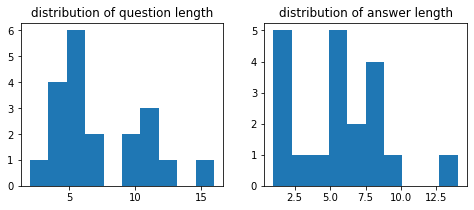

In [9]:
ques_len = [len(q) for q in test_questions]
ans_len = [len(a) for a in test_answers]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(ques_len,bins=10)
plt.title("distribution of question length")
plt.subplot(1,2,2)
plt.hist(ans_len,bins=10)
plt.title("distribution of answer length")
plt.show()

In [6]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        if rnn=="RNN":
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        elif rnn=="GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden, cell=None):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        if rnn in ["RNN","GRU"]:
            output, hidden = self.rnn(output, hidden)
            return output, hidden
        else:
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
            return output, (hidden, cell) 

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        if rnn=="RNN":
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        elif rnn=="GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell=None):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        if rnn in ["RNN","GRU"]:
            output, hidden = self.rnn(output, hidden)
            output = self.softmax(self.out(output[0]))
            return output, hidden
        else:
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
            output = self.softmax(self.out(output[0]))
            return output, (hidden, cell) 

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_len):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.RNN(self.hidden_size, self.hidden_size, batch_first=True)
        if rnn=="RNN":
            self.rnn = nn.RNN(self.hidden_size, self.hidden_size, batch_first=True)
        elif rnn=="GRU":
            self.rnn = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, batch_first=True)
            
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, cell=None):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
#         output, hidden = self.rnn(output, hidden)
        if rnn in ["RNN","GRU"]:
            output, hidden = self.rnn(output, hidden)
            output = F.log_softmax(self.out(output[0]), dim=1)
            return output, hidden, attn_weights
        else:
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
            output = F.log_softmax(self.out(output[0]), dim=1)
            return output, (hidden, cell), attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_len):
    encoder_hidden = encoder.initHidden()
    if rnn in ["RNN","GRU"]:
        encoder_cell=None
    else:
        encoder_cell = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        if rnn in ["RNN","GRU"]:
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
        else:
            encoder_output, (encoder_hidden,encoder_cell) = encoder(
                input_tensor[ei], encoder_hidden, cell=encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[dec_vocab["<SOS>"]]], device=device)

    decoder_hidden = encoder_hidden
    if rnn not in ["RNN","GRU"]:
        decoder_cell = encoder_cell

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if rnn in ["RNN","GRU"]:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
    #             decoder_output, decoder_hidden, decoder_attention = decoder(
    #                 decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, (decoder_hidden, decoder_cell) = decoder(
                    decoder_input, decoder_hidden, cell=decoder_cell)
    #             decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
    #                 decoder_input, decoder_hidden, encoder_outputs, cell=decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if rnn in ["RNN","GRU"]:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
    #             decoder_output, decoder_hidden, decoder_attention = decoder(
    #                 decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, (decoder_hidden, decoder_cell) = decoder(
                    decoder_input, decoder_hidden, cell=decoder_cell)
    #             decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
    #                 decoder_input, decoder_hidden, encoder_outputs, cell=decoder_cell)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == dec_vocab["<EOS>"]:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [9]:
def evaluate(encoder, decoder, sentence, max_length=max_len):
    with torch.no_grad():
        input_tensor = get_encoderinput([sentence])[0]
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        if rnn not in ["RNN","GRU"]:
            encoder_cell = encoder.initHidden()
            
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
            if rnn in ["RNN","GRU"]:
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)
            else:
                encoder_output, (encoder_hidden,encoder_cell) = encoder(
                    input_tensor[ei], encoder_hidden, cell=encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[dec_vocab["<SOS>"]]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        if rnn not in ["RNN","GRU"]:
            decoder_cell = encoder_cell

        decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
# #             decoder_output, decoder_hidden, decoder_attention = decoder(
# #                 decoder_input, decoder_hidden, encoder_outputs)
            if rnn in ["RNN","GRU"]:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
    #             decoder_output, decoder_hidden, decoder_attention = decoder(
    #                 decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, (decoder_hidden, decoder_cell) = decoder(
                    decoder_input, decoder_hidden, cell=decoder_cell)
    #             decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
    #                 decoder_input, decoder_hidden, encoder_outputs, cell=decoder_cell)
    
            #decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == dec_vocab["<EOS>"]:
                #decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(inv_vocab[topi.item()])

            decoder_input = topi.squeeze().detach()
        if len(decoded_words)==0:
            return "i am not sure".split()
        return decoded_words #, decoder_attentions[:di + 1]

In [10]:
#evaluate
def calWordErrorRate1(ytruelist,ypredlist):
    for y in ypredlist:
        if y in ytruelist:
            return 0
    return 1 #error rate counting by word

def calWordErrorRate(ytruelist,ypredlist):
    error=0
    for y in ypredlist:
        if y not in ytruelist:
            error+=1
    return error/len(ypredlist) #error rate counting by word

def computeWER(testset):
    WER = []
    WER_one = []
    for i,sentence in enumerate(testset):
        ytrue = testset[i]
        decoded_translation = evaluate(encoder1, attn_decoder1, sentence)
        e = calWordErrorRate(ytrue,decoded_translation)
        WER.append(e)
        WER_one.append(calWordErrorRate1(ytrue,decoded_translation))
    wer = round(np.mean(WER),3)
    wer1 = round(np.mean(WER_one),3)
    print("WER:",wer," WER counting one word:",wer1)
    return wer,wer1


In [11]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
#     plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    #update method
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
                       
    criterion = nn.NLLLoss()
    
    minwer = 1.0
    record = [None,None]
    for iter in range(1, n_iters + 1):
        ind = np.random.choice(range(ntrain_samples))
        input_tensor = encoder_inp[ind]
        target_tensor = decoder_inp[ind]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            print("train", end=" -- ")
            wer, wer1 = computeWER(questions) #train
            print("test", end=" -- ")
            wer, wer1 = computeWER(test_questions)
            if wer1<=minwer:
                minwer=wer1
                torch.save({'encoder': encoder.state_dict(), 
                            'decoder': decoder.state_dict()}, 
                           f"checkpoint_file_{rnn}")

In [12]:
rnn = "LSTM"
encoder1 = EncoderRNN(VOCAB_SIZE, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, DEC_VOCAB_SIZE).to(device)
#use no atte
trainIters(encoder1, attn_decoder1, 6000, print_every=300)

checkpoint = torch.load(f"checkpoint_file_{rnn}")
encoder1.load_state_dict(checkpoint['encoder'])
attn_decoder1.load_state_dict(checkpoint['decoder'])

0m 2s (- 0m 47s) (300 5%) 3.0872
train -- WER: 0.73  WER counting one word: 0.73
test -- WER: 0.75  WER counting one word: 0.75
0m 5s (- 0m 45s) (600 10%) 3.4029
train -- WER: 0.738  WER counting one word: 0.472
test -- WER: 0.75  WER counting one word: 0.5
0m 7s (- 0m 43s) (900 15%) 3.2530
train -- WER: 0.728  WER counting one word: 0.472
test -- WER: 0.75  WER counting one word: 0.5
0m 10s (- 0m 40s) (1200 20%) 3.1797
train -- WER: 0.772  WER counting one word: 0.506
test -- WER: 0.833  WER counting one word: 0.6
0m 12s (- 0m 38s) (1500 25%) 3.1164
train -- WER: 0.804  WER counting one word: 0.652
test -- WER: 0.806  WER counting one word: 0.6
0m 15s (- 0m 36s) (1800 30%) 2.7862
train -- WER: 0.796  WER counting one word: 0.629
test -- WER: 0.825  WER counting one word: 0.7
0m 18s (- 0m 33s) (2100 35%) 2.5769
train -- WER: 0.83  WER counting one word: 0.652
test -- WER: 0.811  WER counting one word: 0.55
0m 20s (- 0m 31s) (2400 40%) 2.3703
train -- WER: 0.782  WER counting one word: 

<All keys matched successfully>

In [13]:
computeWER(test_questions)

WER: 0.788  WER counting one word: 0.35


(0.788, 0.35)

In [14]:
rnn = "RNN"
encoder1 = EncoderRNN(VOCAB_SIZE, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, DEC_VOCAB_SIZE).to(device)
#use no atte
trainIters(encoder1, attn_decoder1, 6000, print_every=300)

checkpoint = torch.load(f"checkpoint_file_{rnn}")
encoder1.load_state_dict(checkpoint['encoder'])
attn_decoder1.load_state_dict(checkpoint['decoder'])

0m 2s (- 0m 41s) (300 5%) 3.2346
train -- WER: 0.817  WER counting one word: 0.607
test -- WER: 0.8  WER counting one word: 0.55
0m 4s (- 0m 42s) (600 10%) 2.9924
train -- WER: 0.846  WER counting one word: 0.652
test -- WER: 0.885  WER counting one word: 0.65
0m 7s (- 0m 42s) (900 15%) 2.4592
train -- WER: 0.809  WER counting one word: 0.539
test -- WER: 0.828  WER counting one word: 0.5
0m 10s (- 0m 40s) (1200 20%) 1.8344
train -- WER: 0.796  WER counting one word: 0.551
test -- WER: 0.861  WER counting one word: 0.6
0m 12s (- 0m 37s) (1500 25%) 1.4032
train -- WER: 0.822  WER counting one word: 0.528
test -- WER: 0.84  WER counting one word: 0.5
0m 15s (- 0m 35s) (1800 30%) 1.0603
train -- WER: 0.824  WER counting one word: 0.472
test -- WER: 0.805  WER counting one word: 0.35
0m 18s (- 0m 33s) (2100 35%) 0.7070
train -- WER: 0.811  WER counting one word: 0.438
test -- WER: 0.822  WER counting one word: 0.55
0m 20s (- 0m 31s) (2400 40%) 0.5107
train -- WER: 0.792  WER counting one w

<All keys matched successfully>

In [15]:
computeWER(test_questions)

WER: 0.805  WER counting one word: 0.35


(0.805, 0.35)

In [16]:
rnn = "GRU"
encoder1 = EncoderRNN(VOCAB_SIZE, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, DEC_VOCAB_SIZE).to(device)
#use no atte
trainIters(encoder1, attn_decoder1, 6000, print_every=300)

checkpoint = torch.load(f"checkpoint_file_{rnn}")
encoder1.load_state_dict(checkpoint['encoder'])
attn_decoder1.load_state_dict(checkpoint['decoder'])

0m 2s (- 0m 38s) (300 5%) 3.1383
train -- WER: 0.725  WER counting one word: 0.596
test -- WER: 0.725  WER counting one word: 0.65
0m 4s (- 0m 38s) (600 10%) 3.1673
train -- WER: 0.777  WER counting one word: 0.674
test -- WER: 0.8  WER counting one word: 0.75
0m 6s (- 0m 38s) (900 15%) 3.0945
train -- WER: 0.748  WER counting one word: 0.573
test -- WER: 0.8  WER counting one word: 0.7
0m 9s (- 0m 36s) (1200 20%) 2.7928
train -- WER: 0.815  WER counting one word: 0.652
test -- WER: 0.771  WER counting one word: 0.55
0m 11s (- 0m 34s) (1500 25%) 2.6360
train -- WER: 0.827  WER counting one word: 0.64
test -- WER: 0.87  WER counting one word: 0.7
0m 14s (- 0m 33s) (1800 30%) 2.4086
train -- WER: 0.819  WER counting one word: 0.551
test -- WER: 0.801  WER counting one word: 0.5
0m 16s (- 0m 31s) (2100 35%) 2.0373
train -- WER: 0.82  WER counting one word: 0.607
test -- WER: 0.867  WER counting one word: 0.6
0m 19s (- 0m 29s) (2400 40%) 1.8232
train -- WER: 0.824  WER counting one word: 0

<All keys matched successfully>

In [17]:
computeWER(test_questions)

WER: 0.787  WER counting one word: 0.4


(0.787, 0.4)

In [18]:
#show examples of output
for i,sentence in enumerate(test_questions[:5]):
    print("question:"," ".join(sentence))
    print("true answer:"," ".join(test_answers[i]))
    decoded_translation = evaluate(encoder1, attn_decoder1, sentence)
    print("chatbot answer:"," ".join(decoded_translation))
    print()  

question: life is the condition that distinguishes organisms from inorganic matter including
true answer: e capacity for growth reproduction functional activity and continual change
chatbot answer: i am not read

question: can i help you with anything
true answer: yes i have a question
chatbot answer: i am not read

question: of course i am a programmer
true answer: i am indeed
chatbot answer: of course i am a programmer

question: i am also good
true answer: that is good to hear
chatbot answer: that is good

question: who who is but a form following the function of what
true answer: what are you then
chatbot answer: i am but a man in a mask



In [19]:
from termcolor import colored

#Response Fetching
flag=False
print(colored("NEO:\nI am Neo. If you want to exit, type ciao",'blue',attrs=['bold']))
while(flag==True):
    print(colored("\nYOU:",'red',attrs=['bold']))
    u_input = input()
    if(u_input!='ciao'):
        print(colored("\nNEO:",'blue',attrs=['bold']))
        sentence = mysplit(u_input)
        decoded_translation = evaluate(encoder1, attn_decoder1, sentence)
        decoded_sentence = " ".join(decoded_translation)
        print(colored(decoded_sentence.strip().capitalize(),'blue'))
    else:
        flag=False
        print(colored("\nNEO: Bye! take care..",'blue', attrs=['bold']))

NEO:
I am Neo. If you want to exit, type ciao
